In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/Users/lenasalzmann/dev/dbs-eeg-sync', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages']


In [2]:
import numpy as np
import pandas as pd
import mne
import os
import matplotlib.pyplot as plt

import mne
mne.viz.set_browser_backend('matplotlib')  # Use matplotlib in notebook, instead of Qt
from scipy.signal import find_peaks, resample, savgol_filter

from source.power_calculater import  compute_eeg_power, compute_samplewise_eeg_power

from source.sync_artefact_finder import detect_eeg_drop_onset_window

Using matplotlib as 2D backend.


In [3]:
# sub_ids = [ 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011', 'P4-2012']

sub_ids = ['P4-2012']

block = 'baseline' #'baseline', 'treadmill', 'pre8walk'

dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


## EEG drop index detection

In [17]:
# read and plot /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/EEG/baseline/baseline_raw.set
# raw = mne.io.read_raw_eeglab(r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/EEG/baseline/baseline_raw.set", preload=True)
# raw_prep = mne.io.read_raw_eeglab(r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/ProcessedData/EEG/baseline/baseline_prep.set", preload=True)


raw = mne.io.read_raw_eeglab(r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/EEG/baseline/baseline_raw.set", preload=True)


eeg_fs = raw.info['sfreq']  
freq_low, freq_high = 110, 120
channel_name = 'O1'
eeg_power, time_axis = compute_eeg_power(raw, freq_low, freq_high, channel=channel_name, plot=False)
# print the channel name
print(f"channel_name: {channel_name}")

# Get the drop index 
drop_idx, _, _ = detect_eeg_drop_onset_window(eeg_power, eeg_fs, plot=True)


channel_name: O1


In [5]:
# check if raw and raw_prep have the same number of samples
raw.n_times == raw.n_times
# # check if raw and raw_prep have the same sampling frequency
# raw.info['sfreq'] == raw_prep.info['sfreq']
# # # check if raw and raw_prep have the same channel names
# raw.ch_names == raw_prep.ch_names


np.True_

---
Processing subject P4-2012 for block pre8walk...


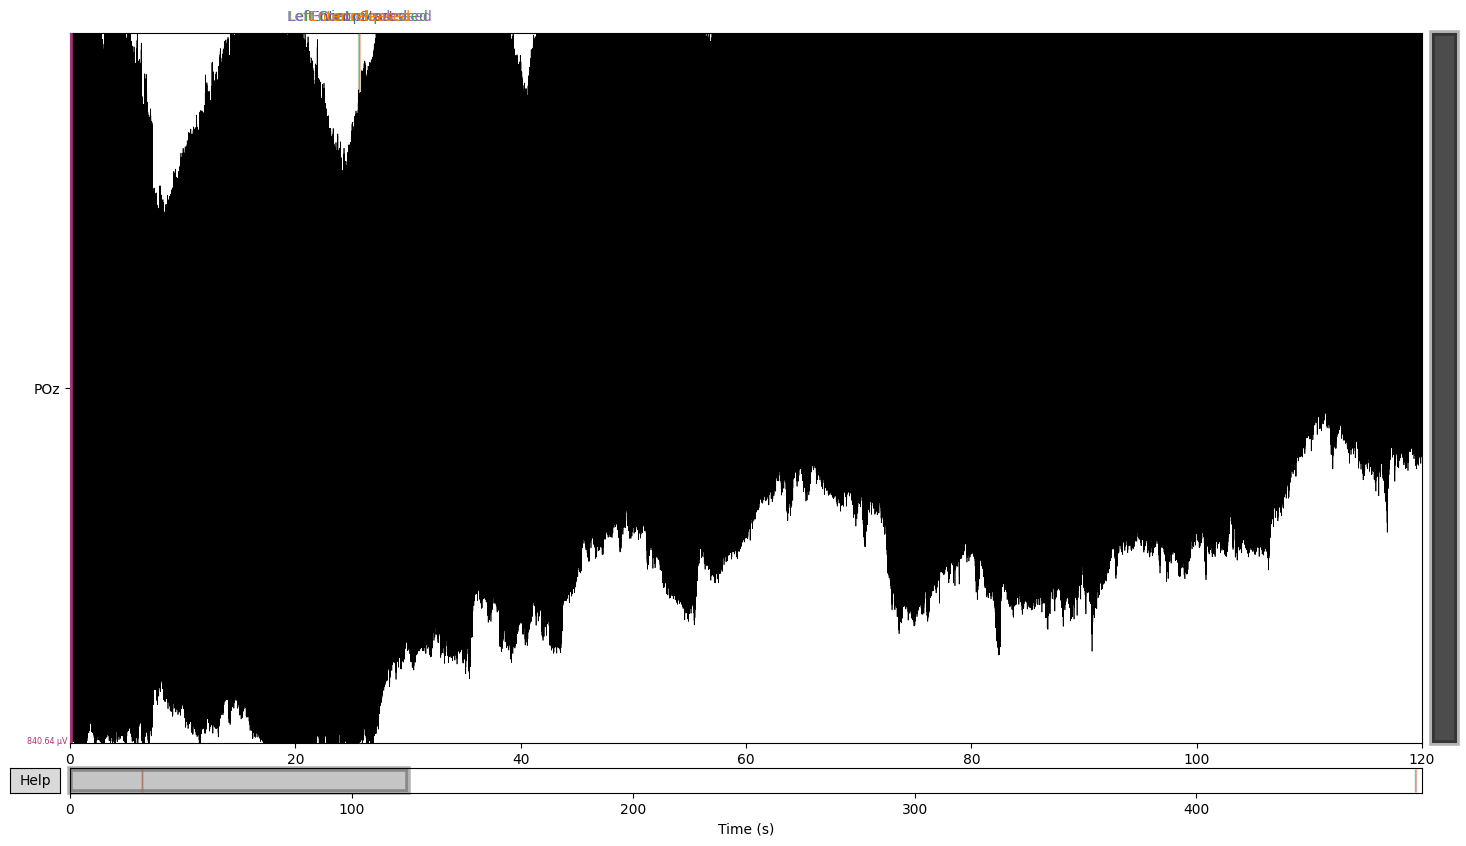

In [16]:
# loop through subjects

sub_id = 'P4-2012'

print(f"---\nProcessing subject {sub_id} for block {block}...")
eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
eeglab_file_path = os.path.join(*eeglab_file_path_components)
# check if the file exists, if not, skip the subject
if not os.path.exists(eeglab_file_path):
    print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
#  Load the EEG data
eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True);
eeg_fs = eeg_raw.info['sfreq']

# plot the POz channel time series in the first 120 seconds
eeg_raw.plot(duration=120, start=0, picks=['POz'], scalings='auto', n_channels=1, color='black', show=True);

In [7]:
# # loop through subjects

# for sub_id in sub_ids:

#     print(f"---\nProcessing subject {sub_id} for block {block}...")
#     eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
#     eeglab_file_path = os.path.join(*eeglab_file_path_components)
#     # check if the file exists, if not, skip the subject
#     if not os.path.exists(eeglab_file_path):
#         print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
#         continue
#     #  Load the EEG data
#     eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
#     eeg_fs = eeg_raw.info['sfreq']

#     # if subject is not P4-2007, use the default frequency range
#     if sub_id == 'P4-2007':
#         freq_low, freq_high = 100, 120
        
#     else:   
#         freq_low, freq_high = 100, 130

#     # Get the EEG power for the P0z channel
#     channel_name = 'CPz'
#     eeg_power, time_axis = compute_eeg_power(eeg_raw, freq_low, freq_high, channel=channel_name, plot=False)
    
#     # Get the drop index 
#     drop_idx, _, _ = detect_eeg_drop_onset_window(eeg_power, eeg_fs, plot=True)
#     # add subId to the title of the plot
#     # plt.title(f"{sub_id} - {channel_name}")
#     # plt.show()

# Check drop detection for all subjects, all channels


Processing P4-2012...


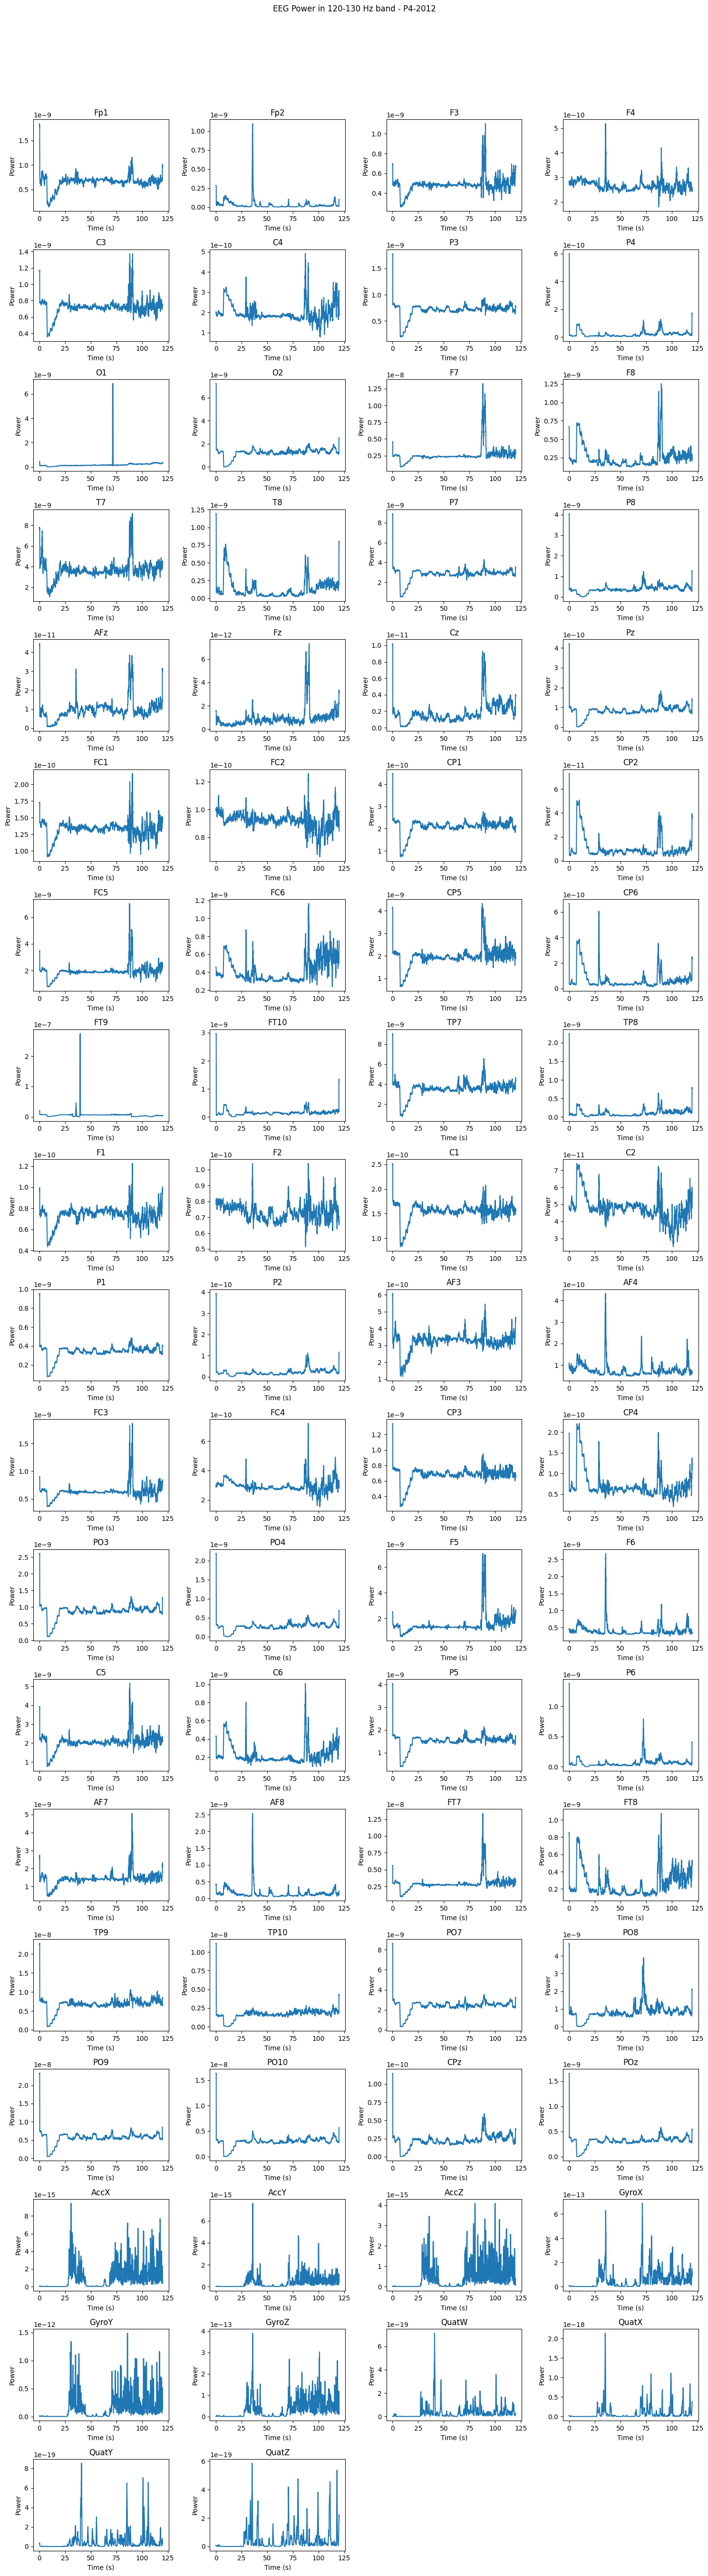

In [18]:
def plot_power_grid(sub_ids, block, dataDir_server):
    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 100, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))
        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_samplewise_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch,
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

        plt.suptitle(f"EEG Power in 120-130 Hz band - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show();

# Example usage
sub_ids = [ 'P4-2012']
block = 'pre8walk' # 'baseline', 'treadmill', 'pre8walk'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
plot_power_grid(sub_ids, block, dataDir_server)

## ALL SUBJECTS

In [14]:
def plot_power_grid(sub_ids, block, dataDir_server):
    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 100, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))
        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch,
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

        plt.suptitle(f"EEG Power in 120-130 Hz band - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009']
block = 'treadmill' # 'baseline', 'treadmill'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
# plot_power_grid(sub_ids, block, dataDir_server)

In [ ]:
def plot_power_grid(sub_ids, block, dataDir_server):
    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 110, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))
        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_samplewise_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

        plt.suptitle(f"EEG Power in 120-130 Hz band - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

sub_ids = [ 'P4-2001','P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
block = 'pre8walk' # 'baseline', 'treadmill'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
# plot_power_grid(sub_ids, block, dataDir_server)

# Test new method

In [ ]:
# EEG-DBS Artifact Detection and Synchronization Model

import numpy as np
import scipy.signal as signal
import mne
import matplotlib.pyplot as plt

# 1. Preprocess EEG without changing sample alignment

def preprocess(data, fs, band=None):
    if band:
        sos = signal.butter(4, band, btype='bandpass', fs=fs, output='sos')
        data = signal.sosfiltfilt(sos, data)  # Zero-phase filtering
    return data

# 2. Detect Artifact Events

def detect_artifacts(data, fs, threshold=5.0):
    diff = np.diff(data)
    zscore = (diff - np.mean(diff)) / np.std(diff)
    artifact_idx = np.where(np.abs(zscore) > threshold)[0]
    return artifact_idx

# 3. Example Pipeline for MNE data

def detect_eeg_artifacts(eeg_raw, fs, band=[1, 100], threshold=5.0):
    eeg_data = eeg_raw.get_data(picks='eeg')  # Pick only EEG channels
    ch_names = eeg_raw.ch_names
    
    eeg_proc = {ch: preprocess(eeg_data[idx, :], fs, band) for idx, ch in enumerate(ch_names)}
    eeg_artifacts = {ch: detect_artifacts(eeg_proc[ch], fs, threshold) for ch in eeg_proc}
    
    return eeg_proc, eeg_artifacts

# 4. Plot EEG with Detected Artifacts

def plot_eeg_artifacts(eeg_proc, eeg_artifacts, fs):
    time = lambda data: np.arange(len(data)) / fs
    for ch in eeg_proc:
        plt.figure(figsize=(10, 4))
        plt.plot(time(eeg_proc[ch]), eeg_proc[ch], label='EEG')
        plt.scatter(time(eeg_proc[ch])[eeg_artifacts[ch]], eeg_proc[ch][eeg_artifacts[ch]], color='red', label='Artifact', marker='x')
        plt.title(f'Channel: {ch}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


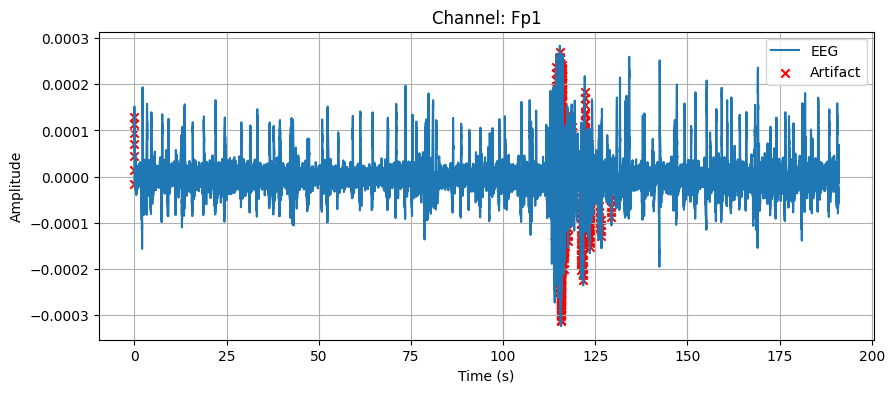

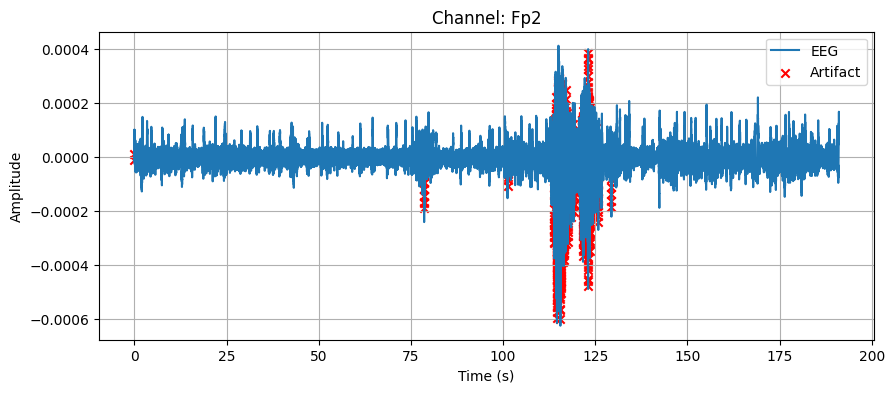

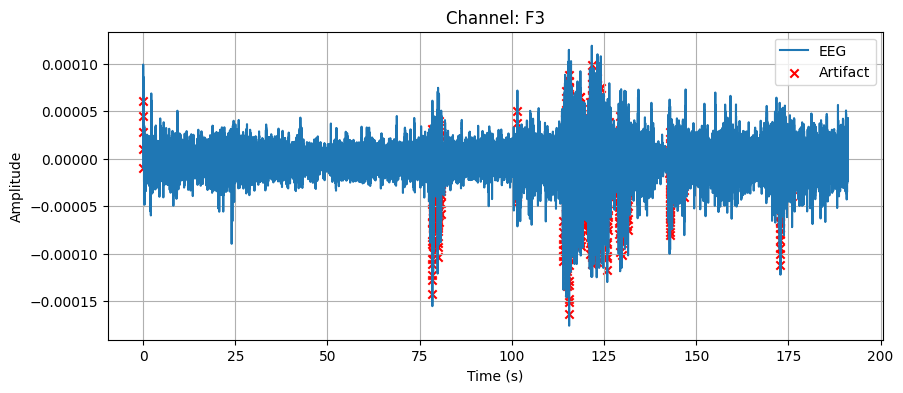

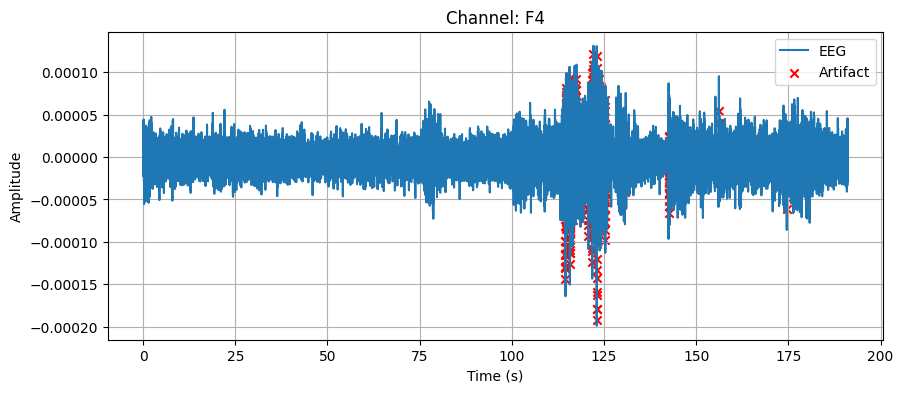

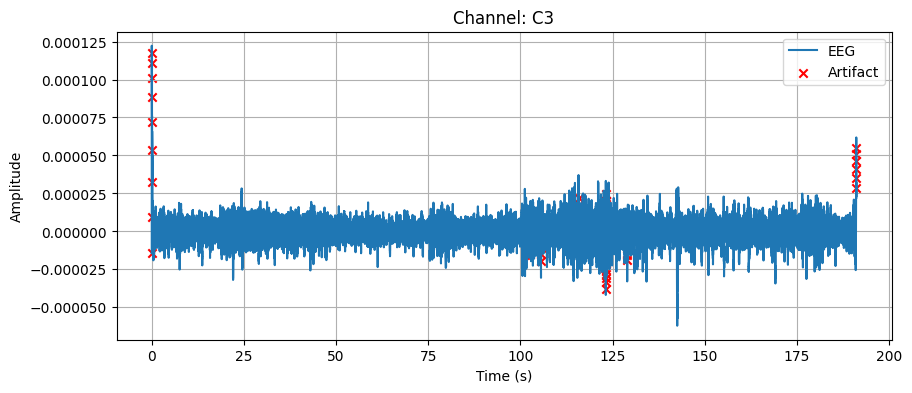

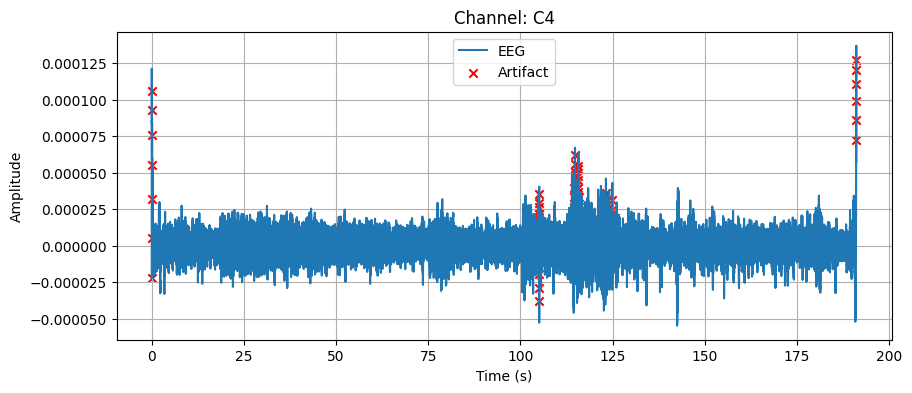

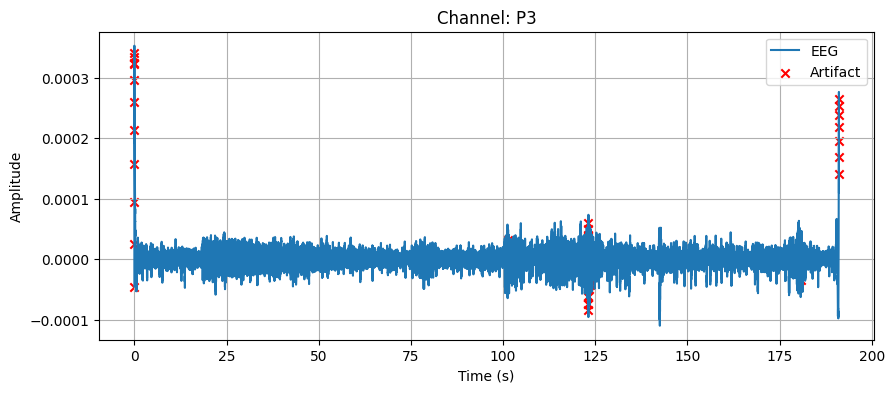

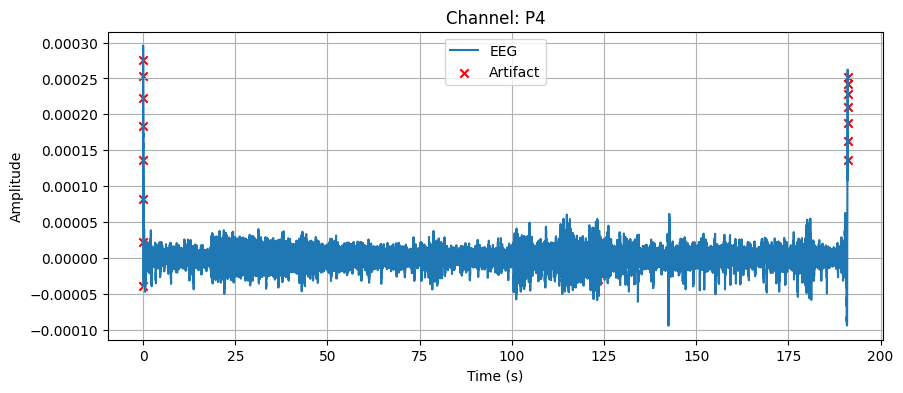

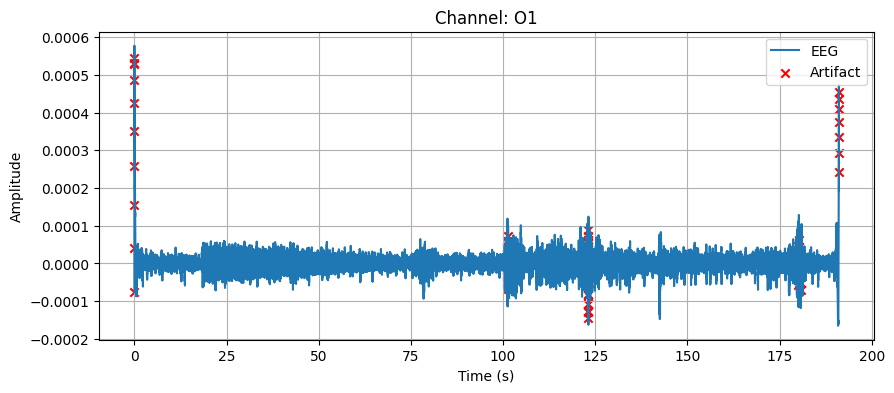

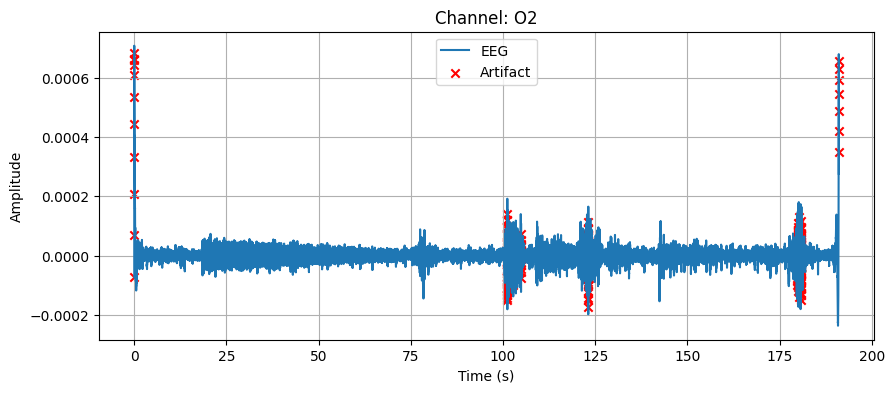

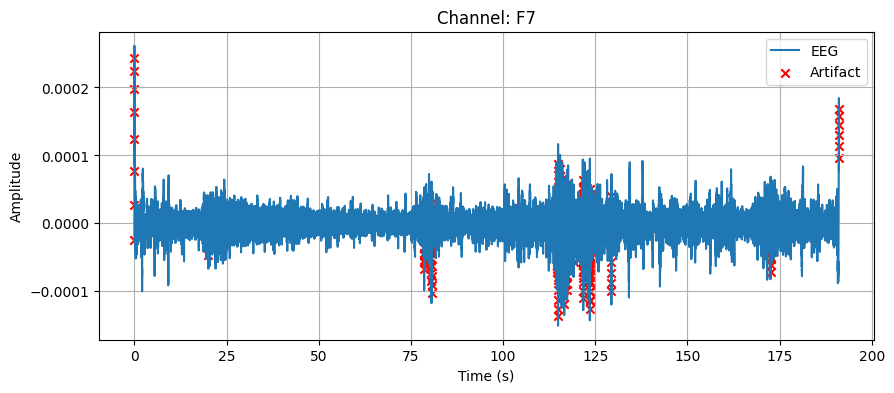

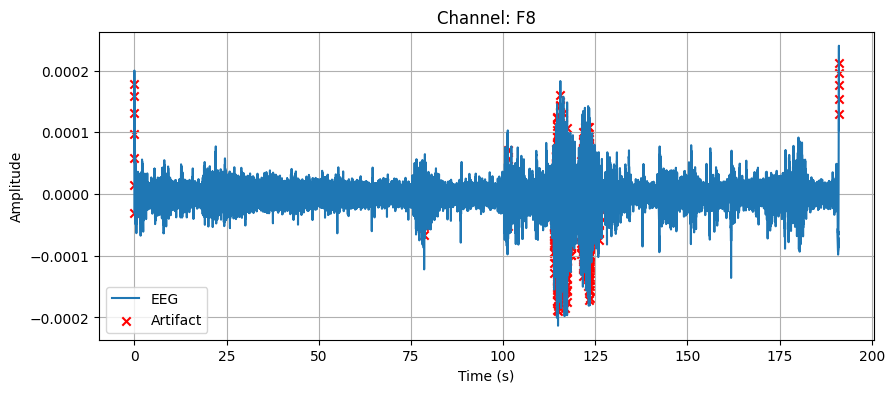

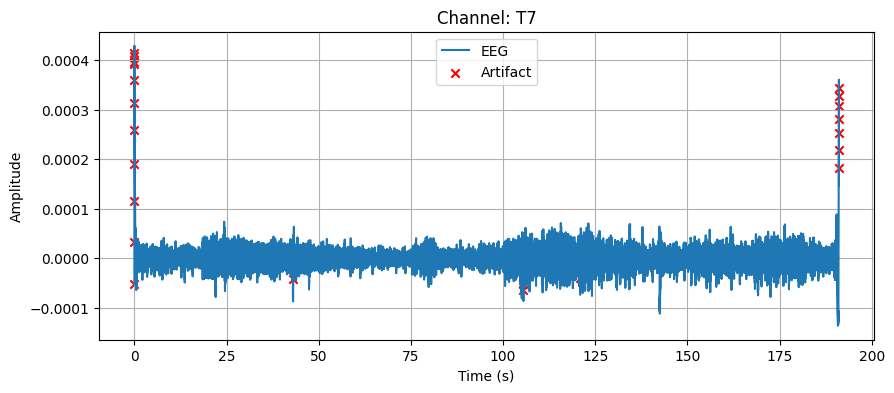

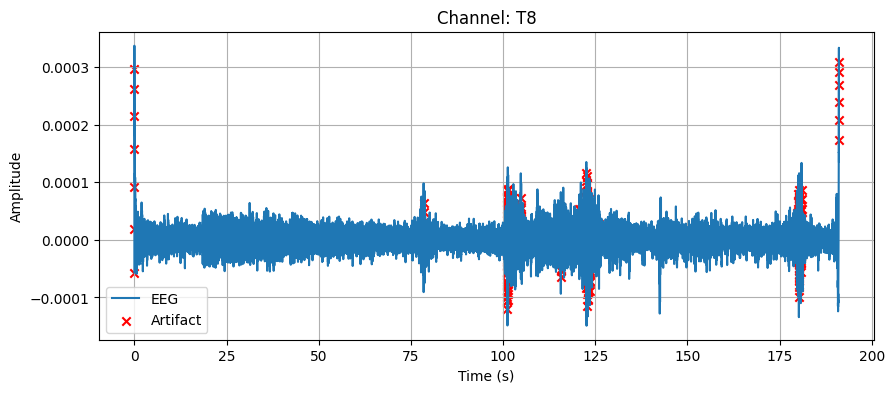

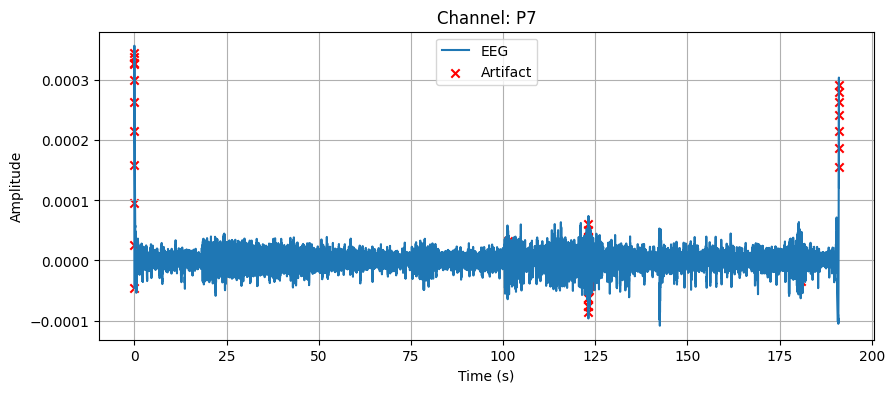

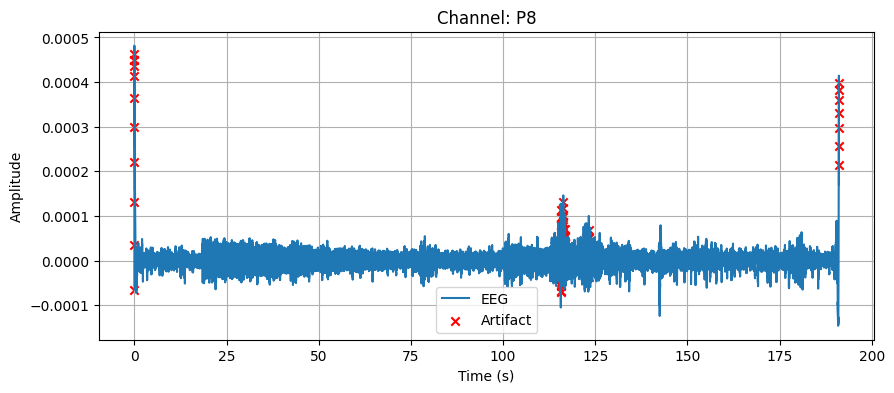

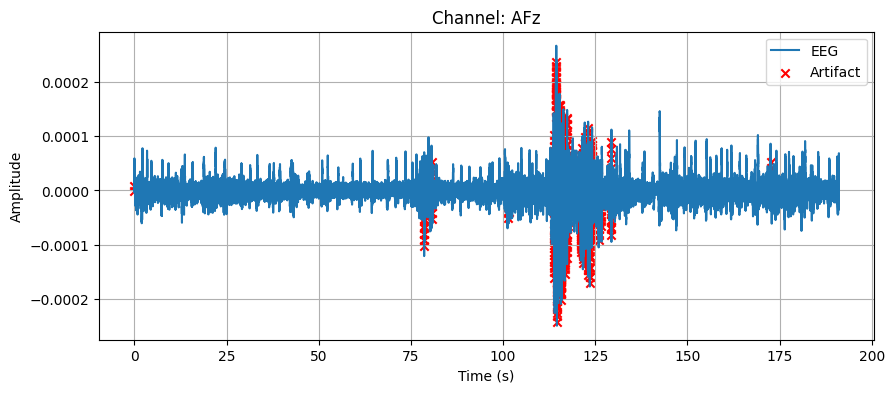

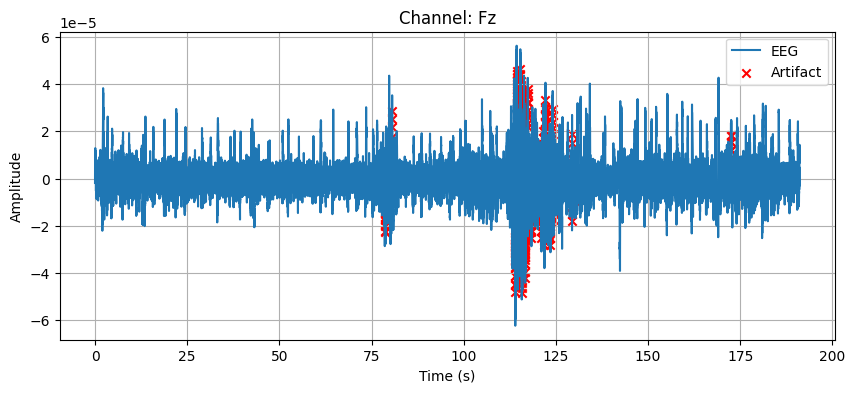

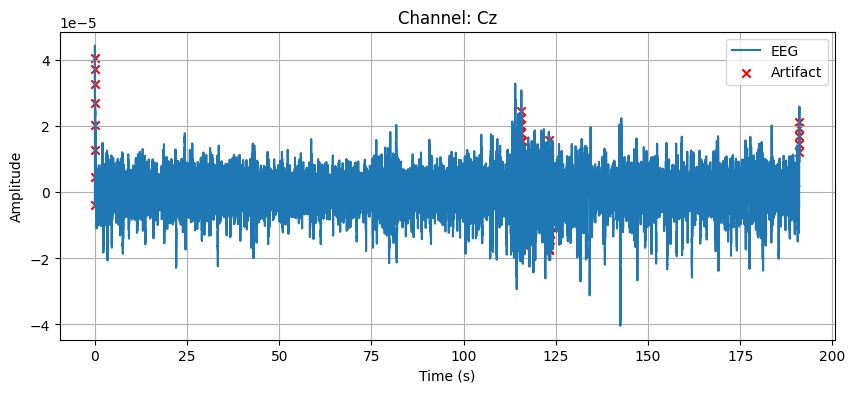

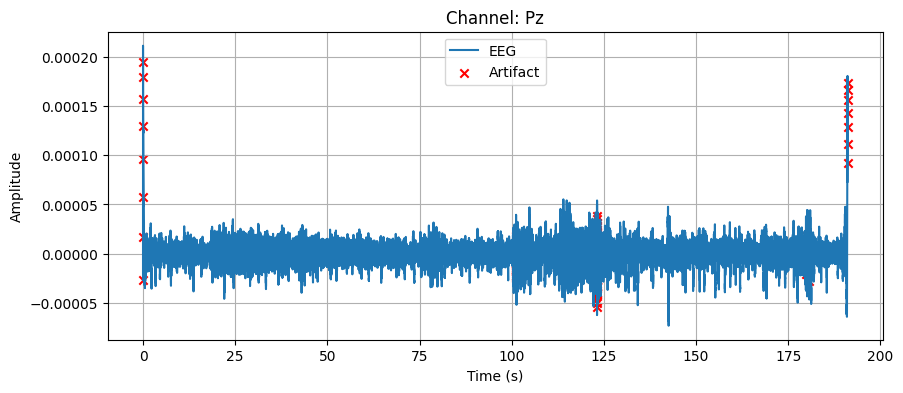

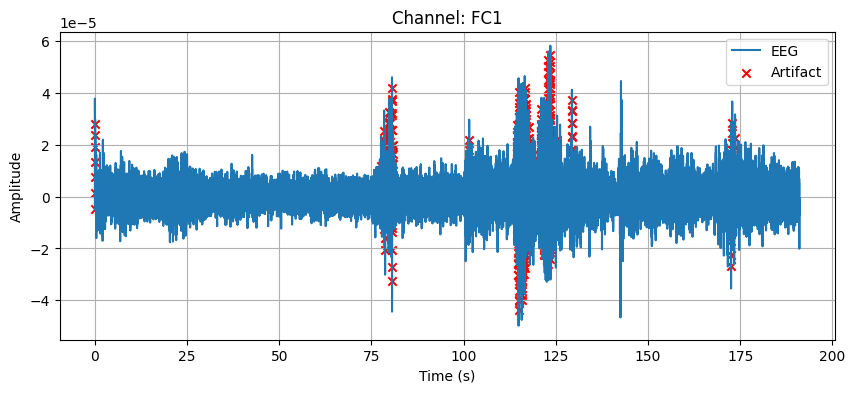

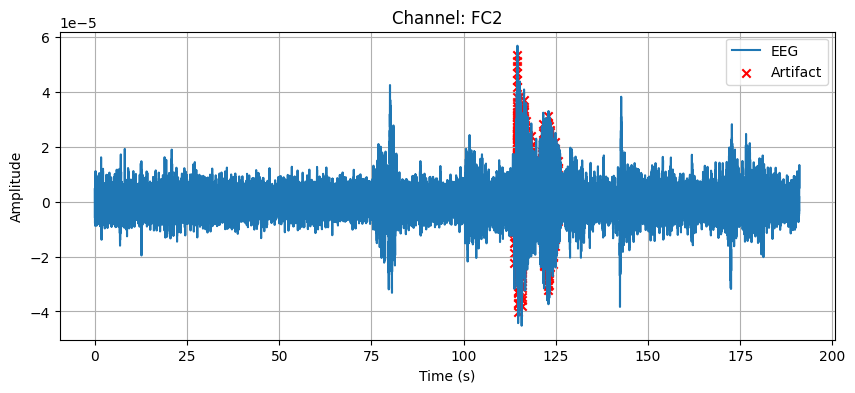

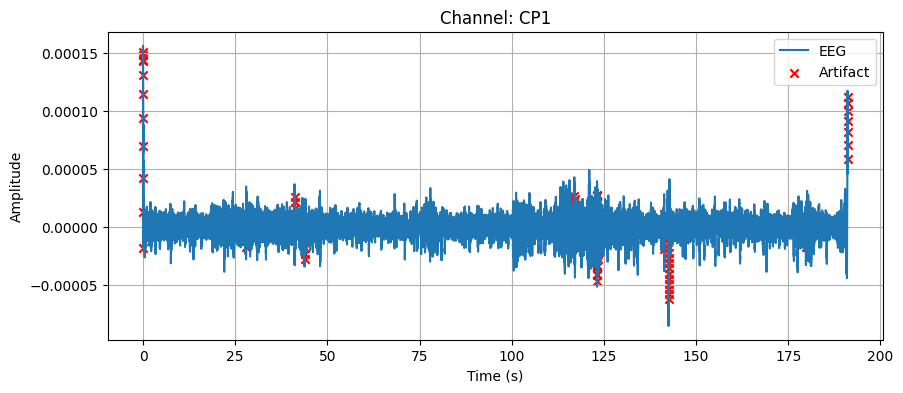

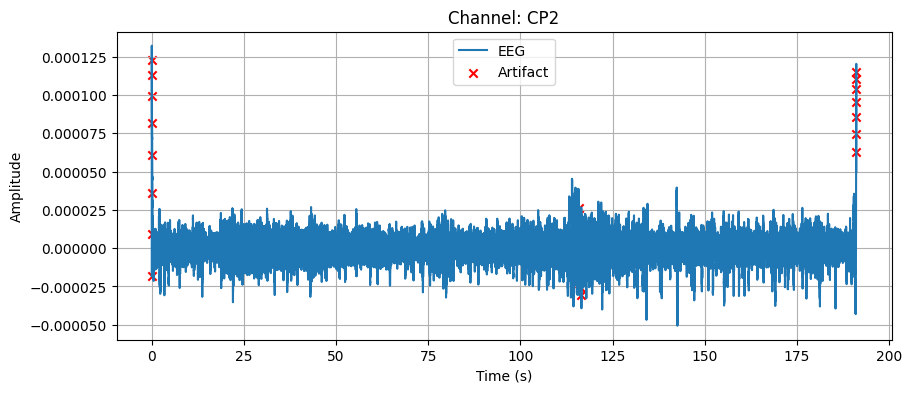

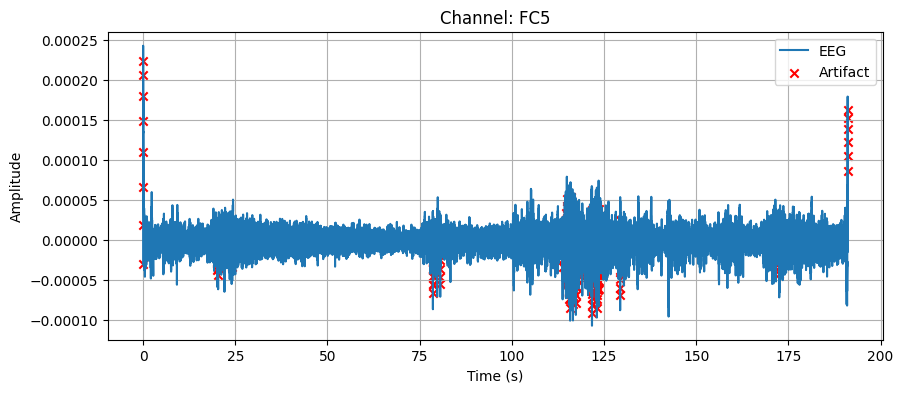

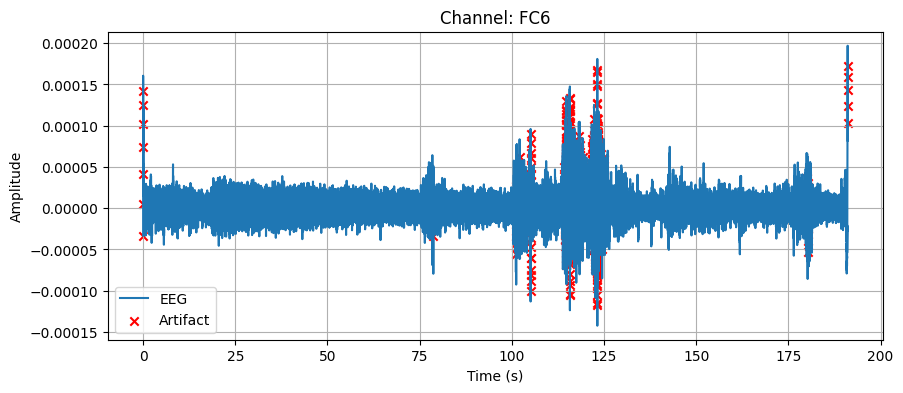

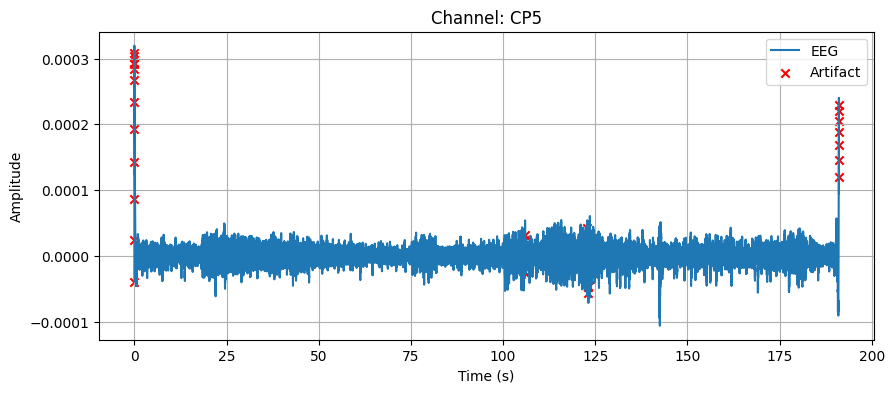

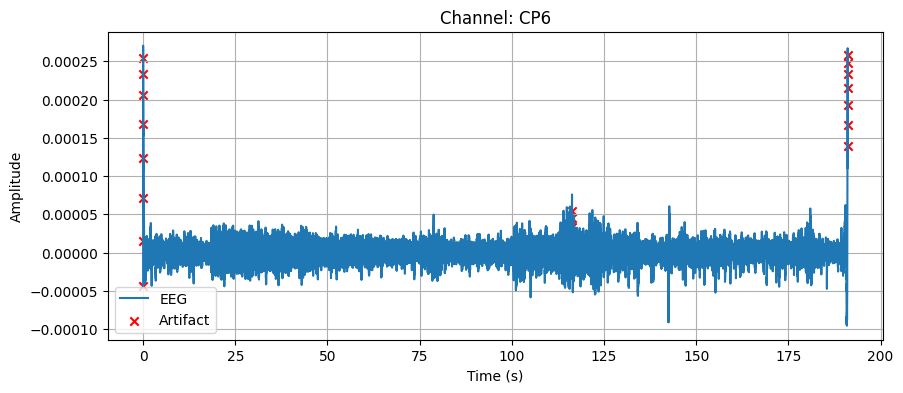

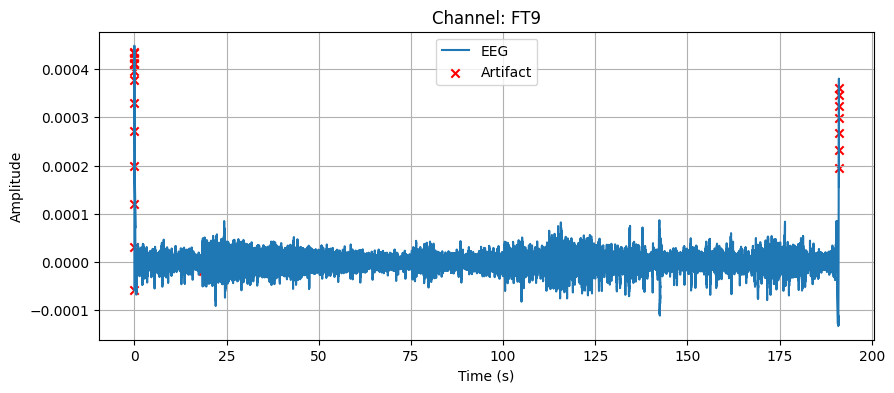

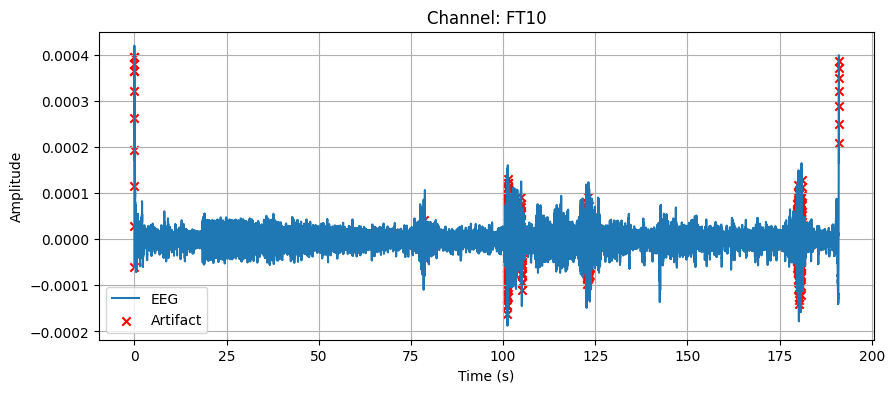

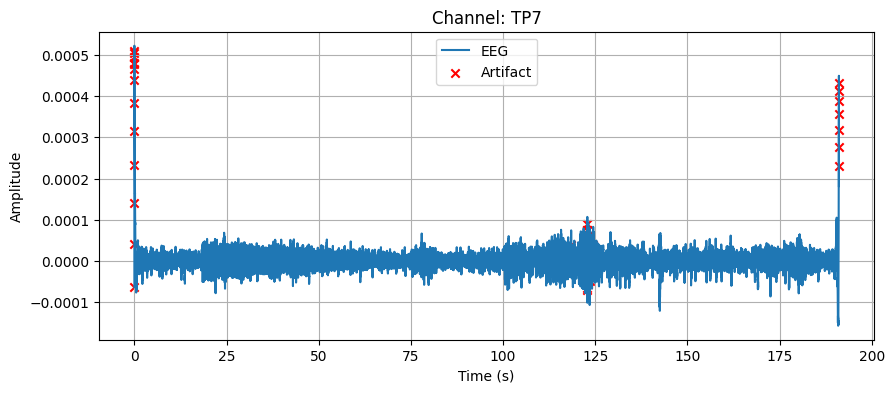

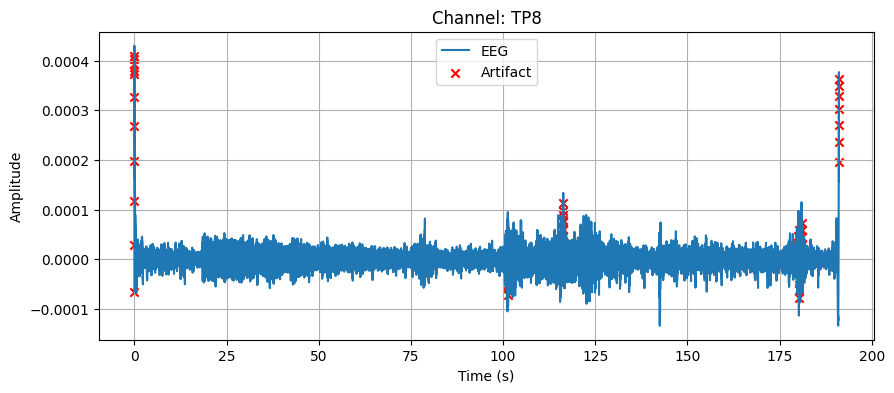

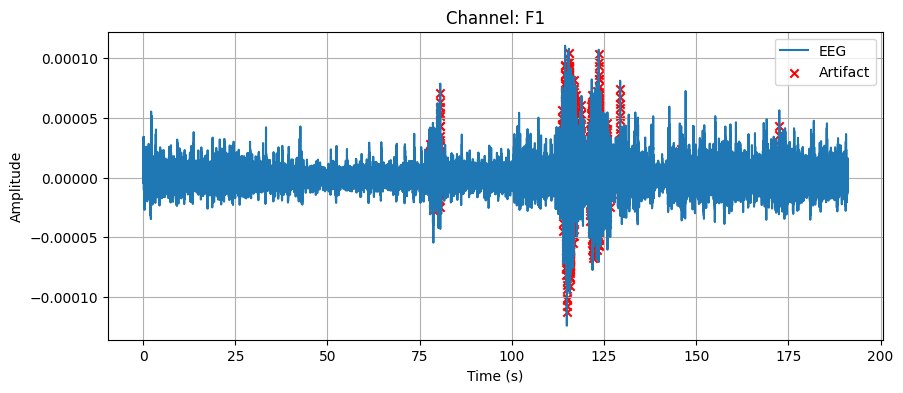

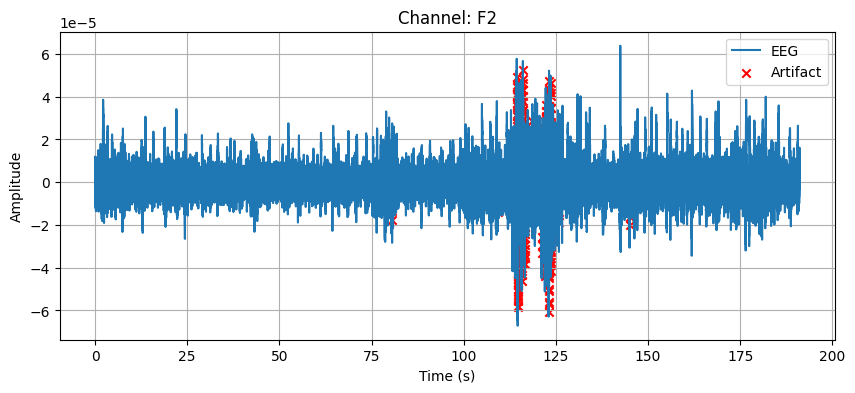

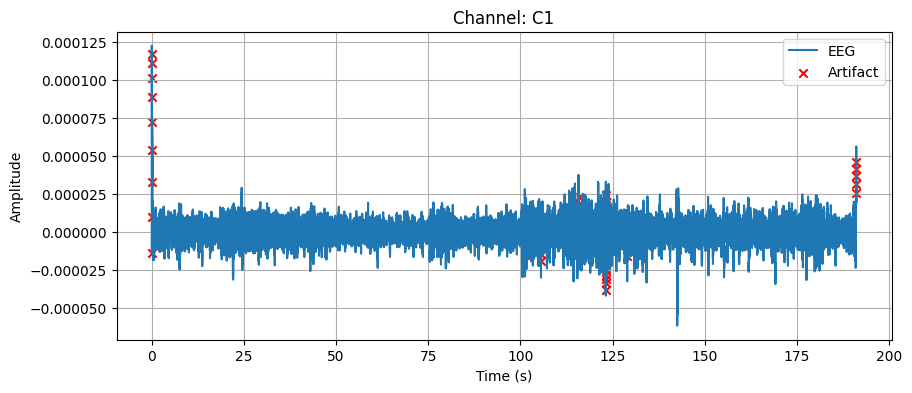

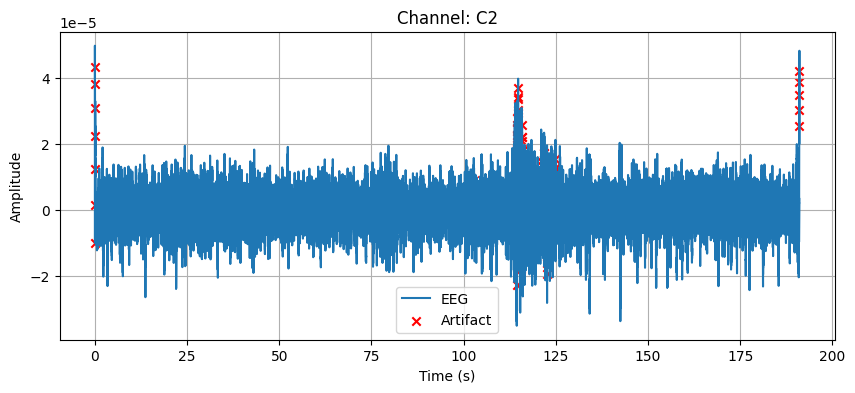

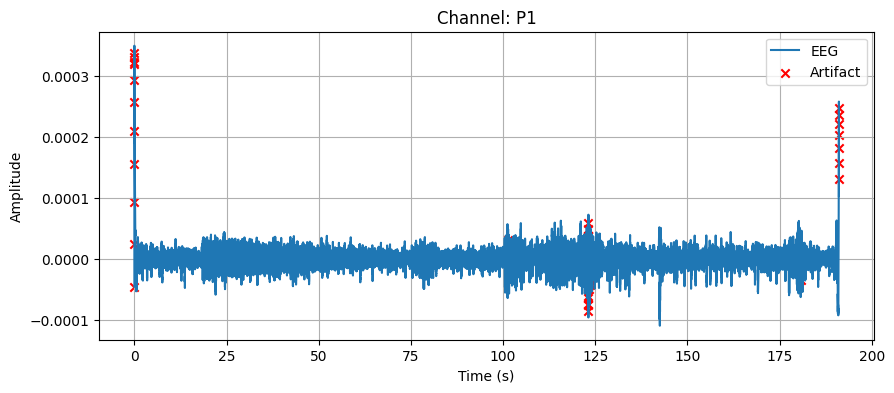

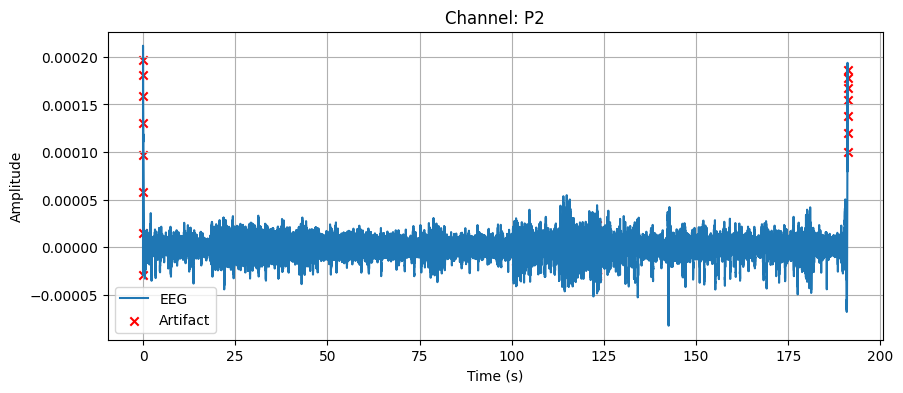

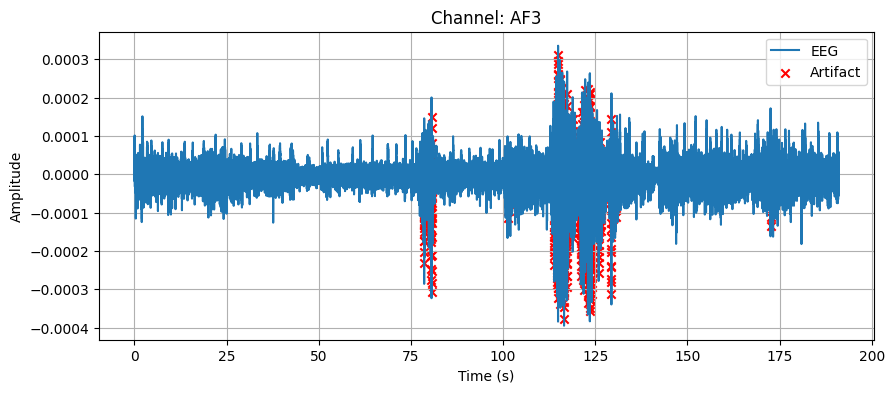

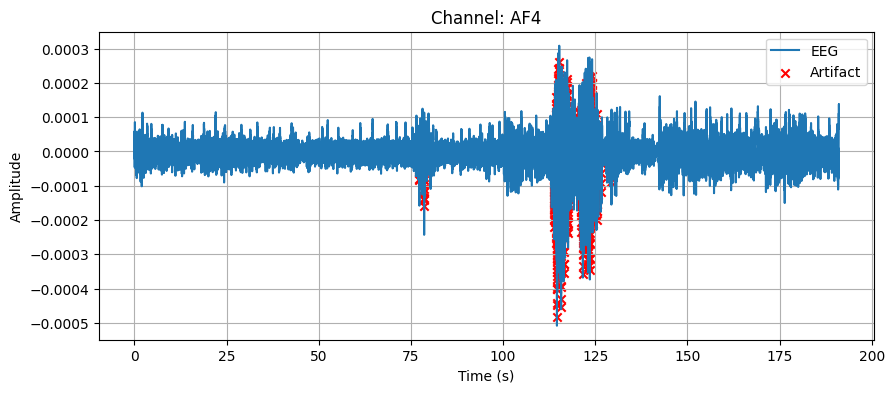

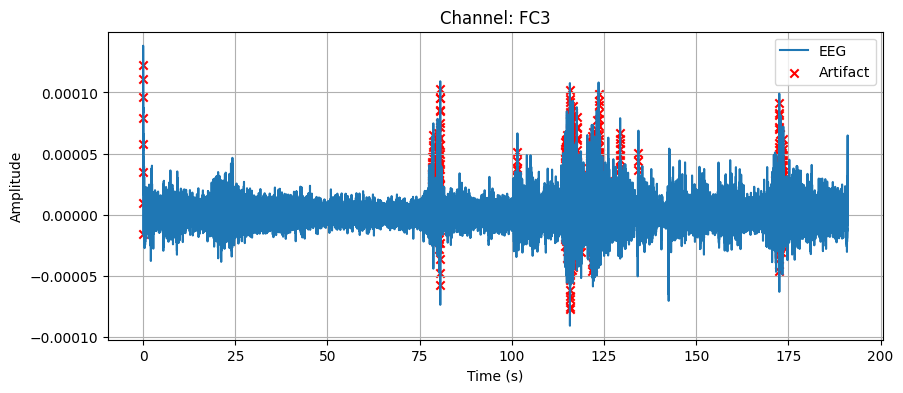

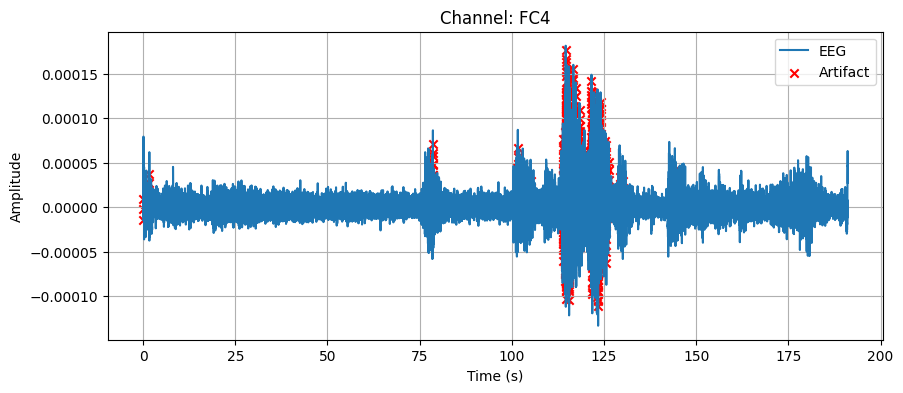

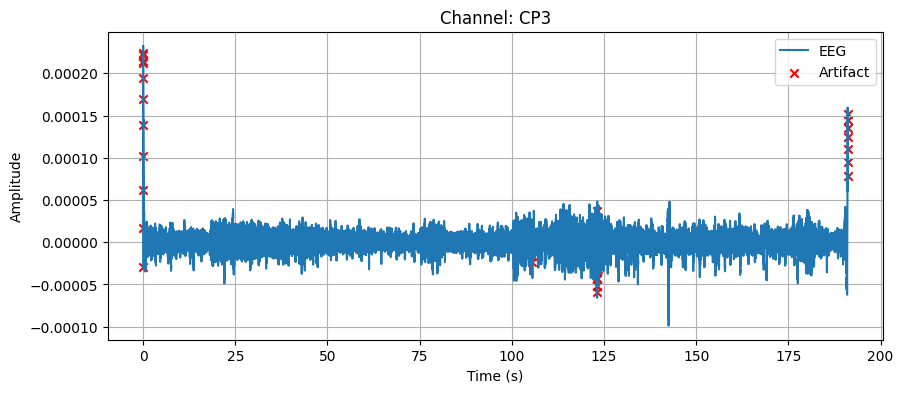

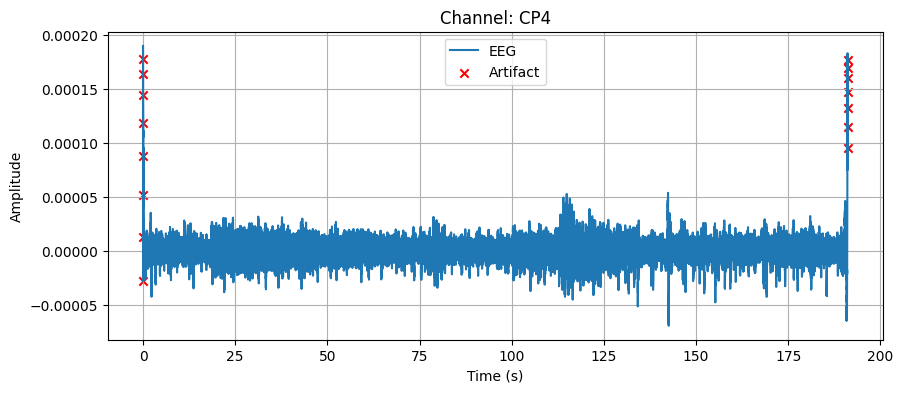

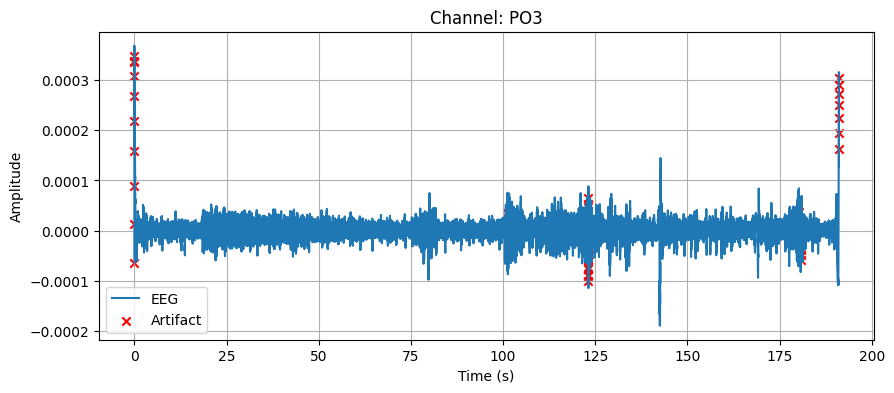

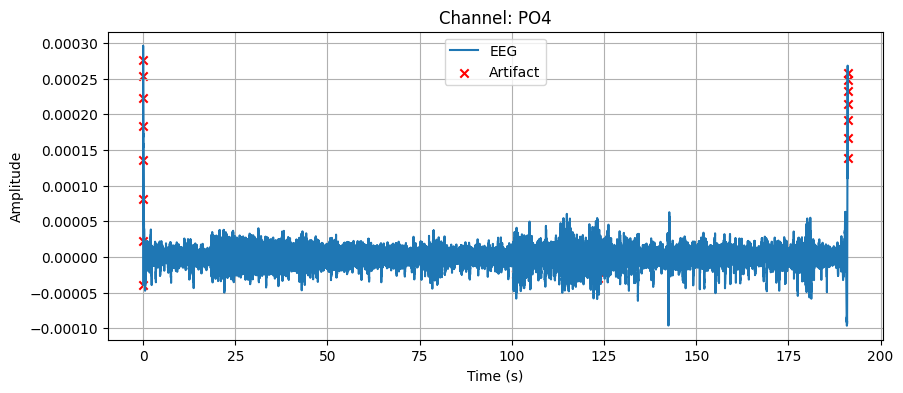

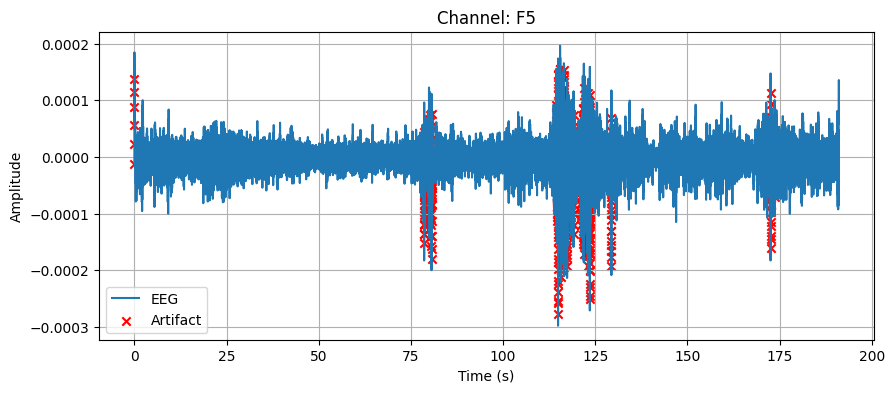

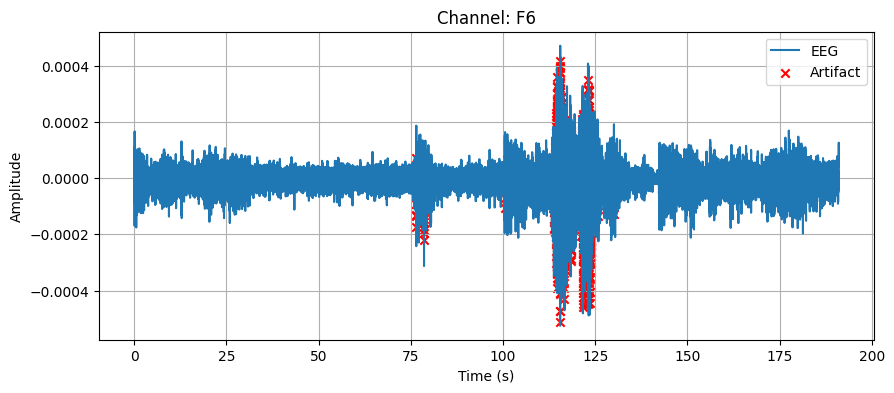

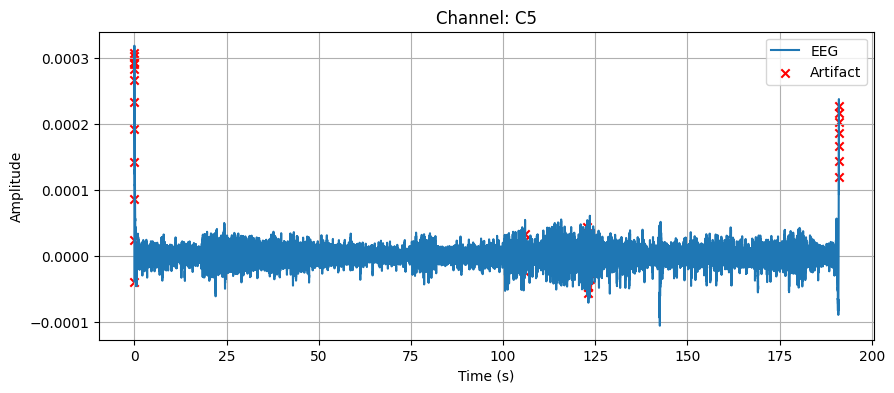

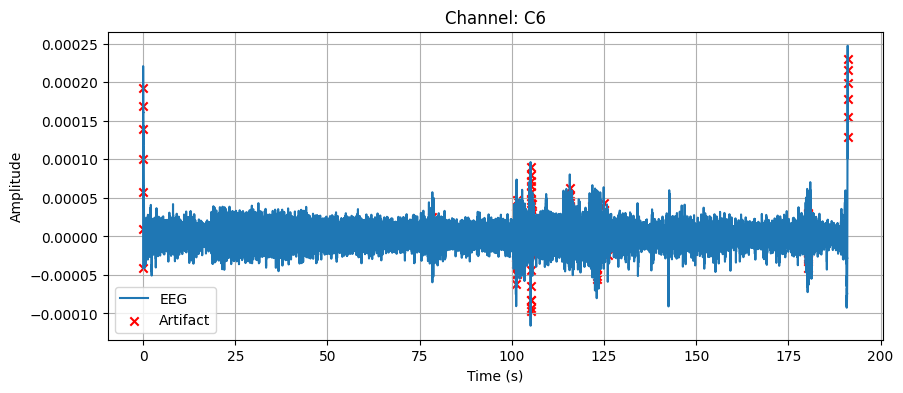

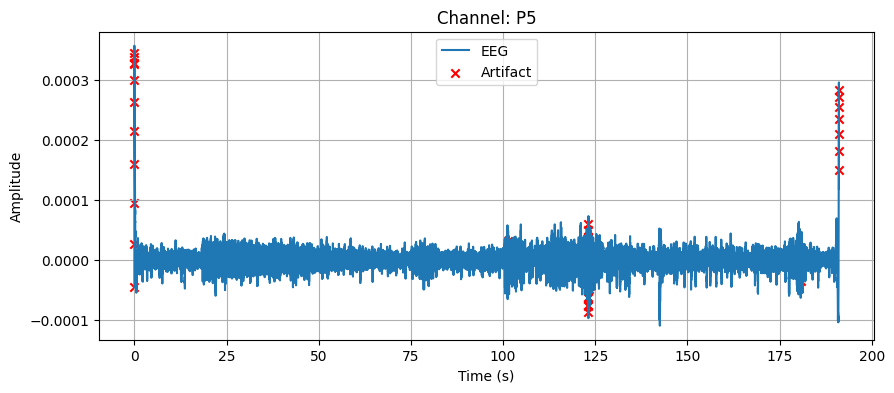

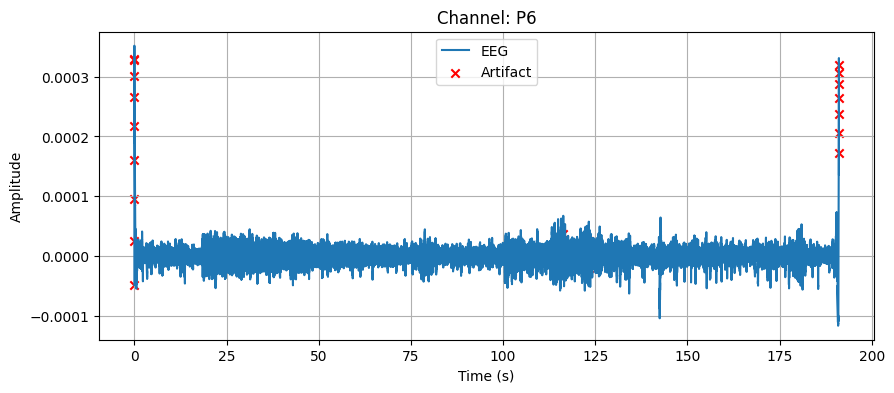

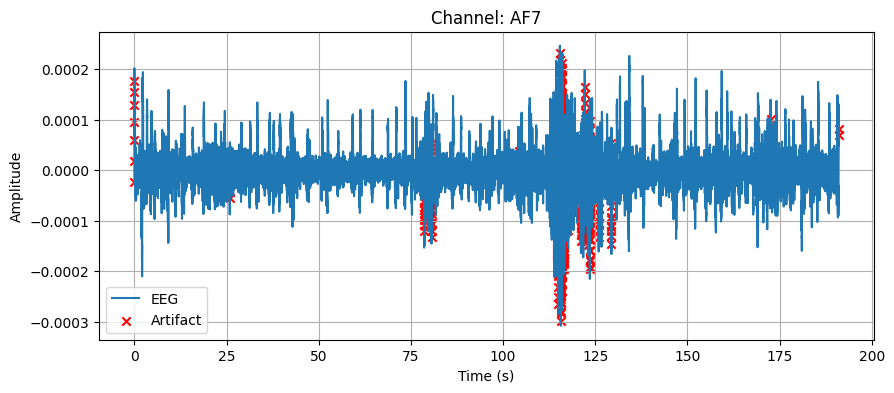

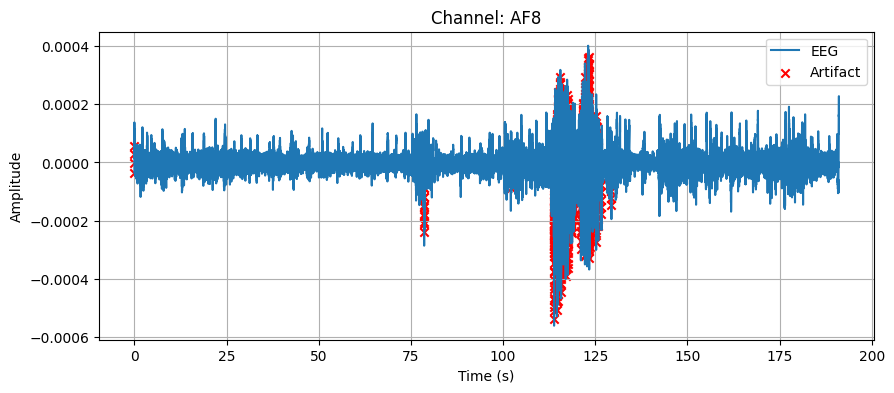

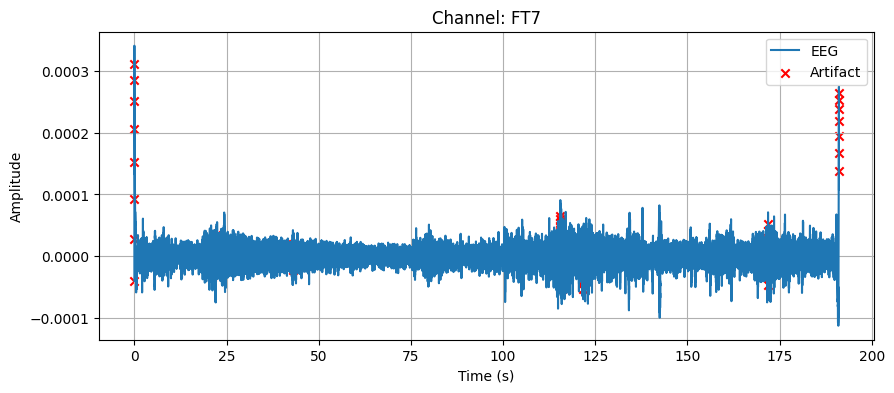

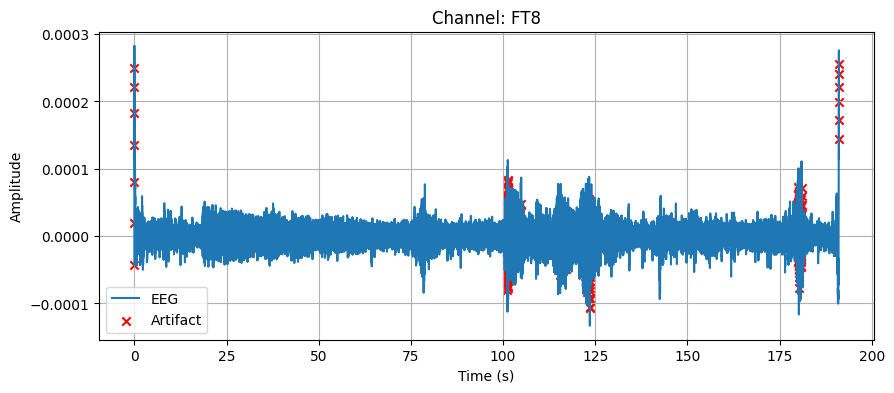

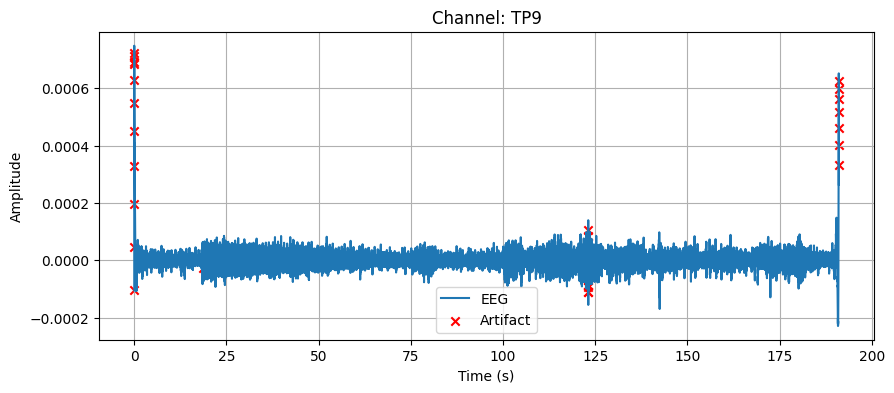

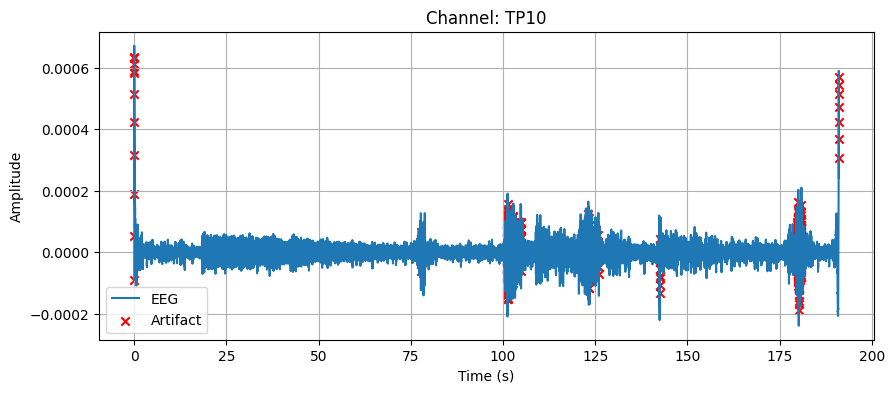

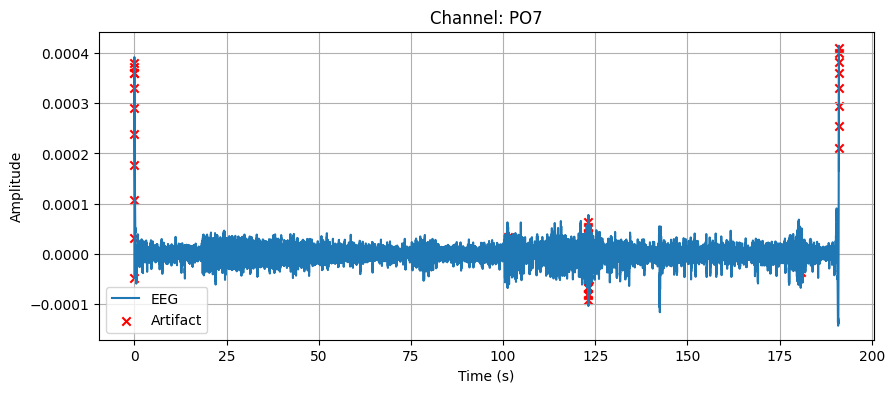

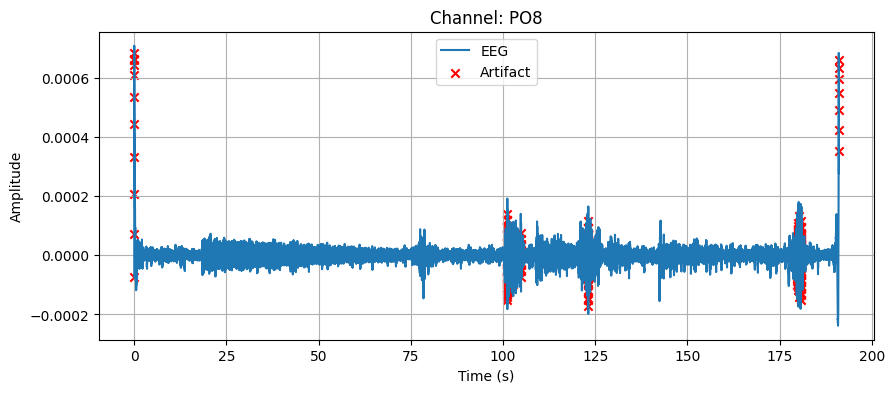

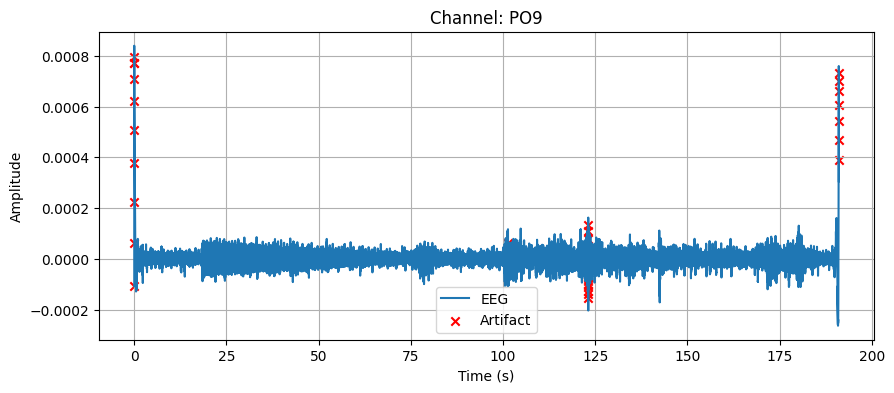

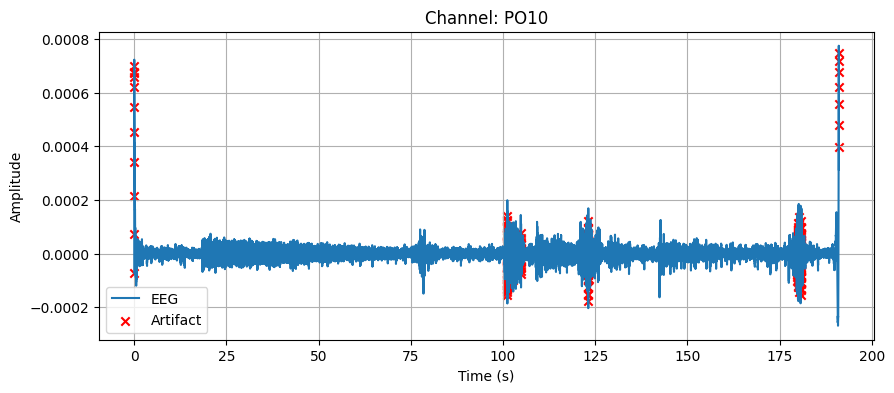

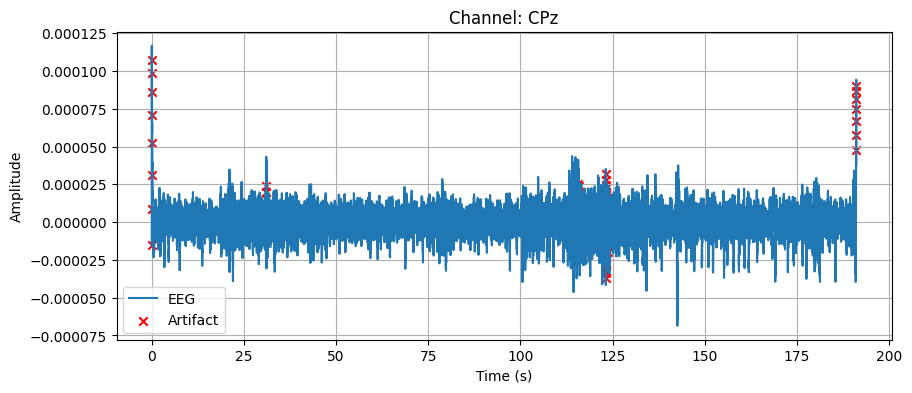

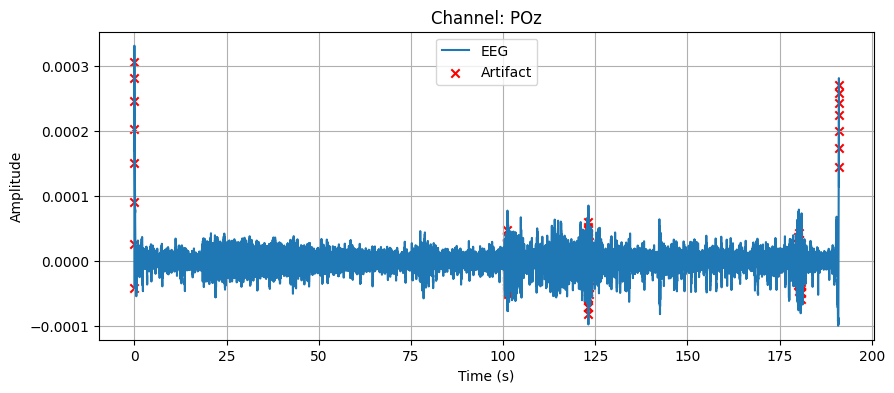

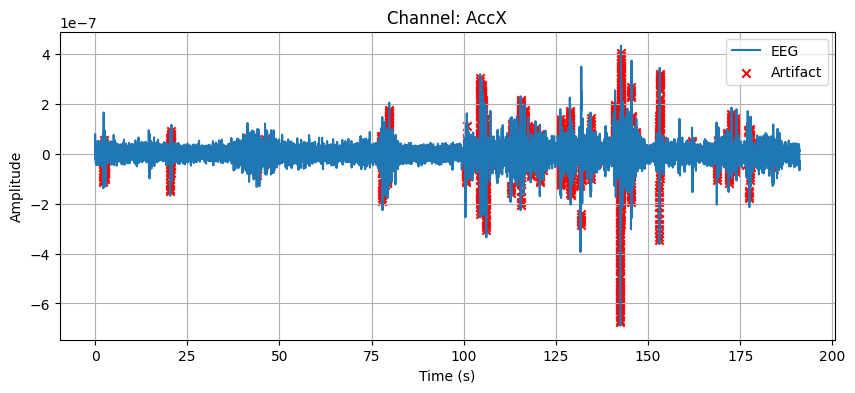

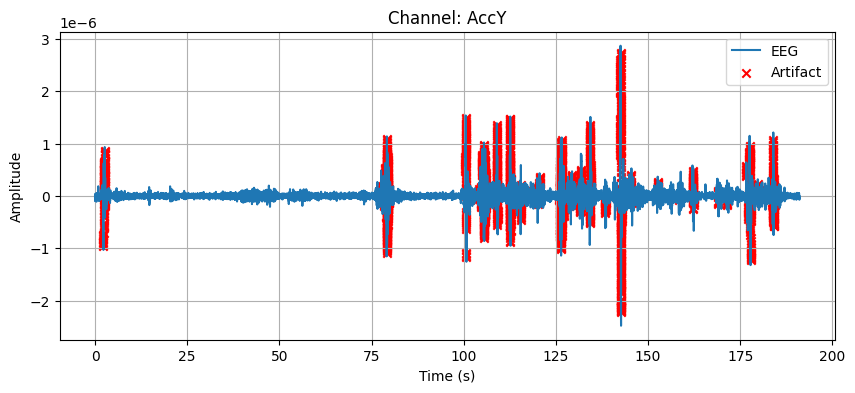

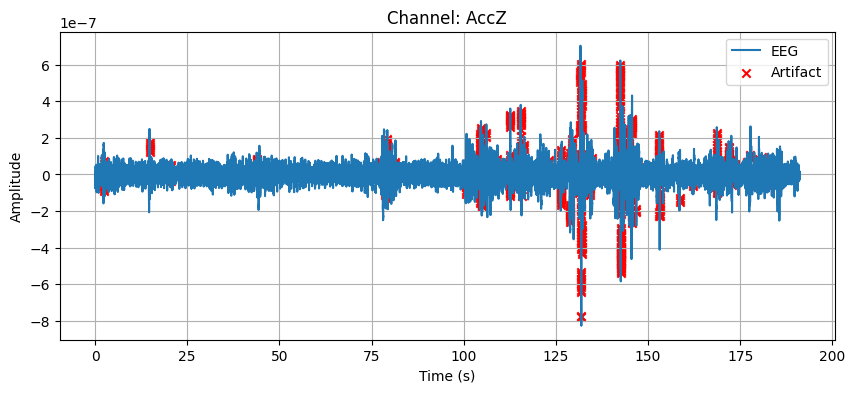

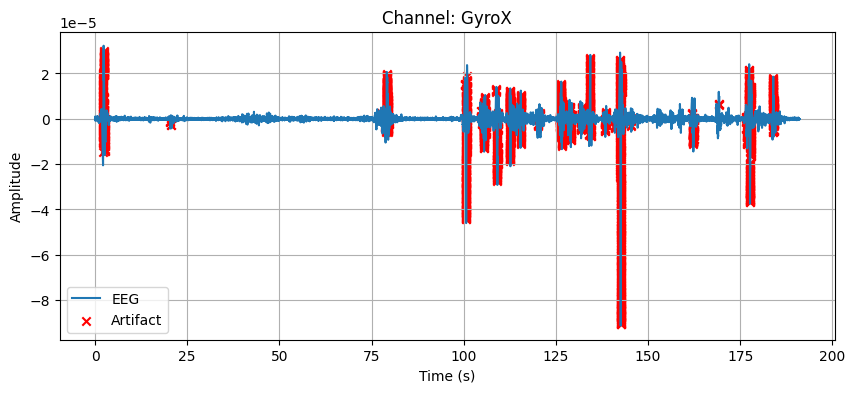

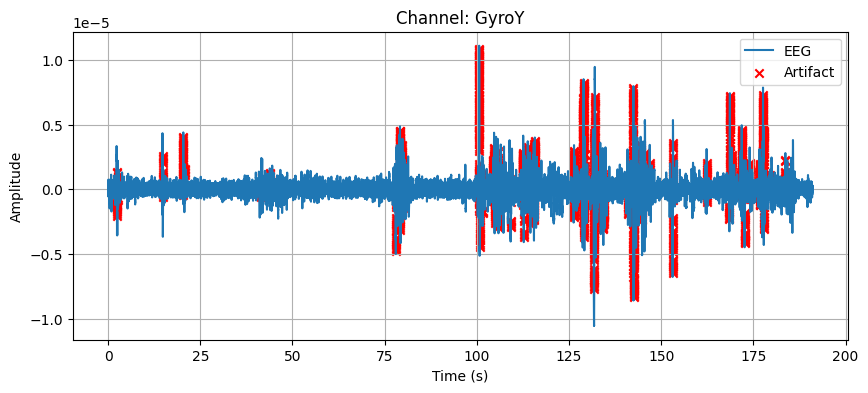

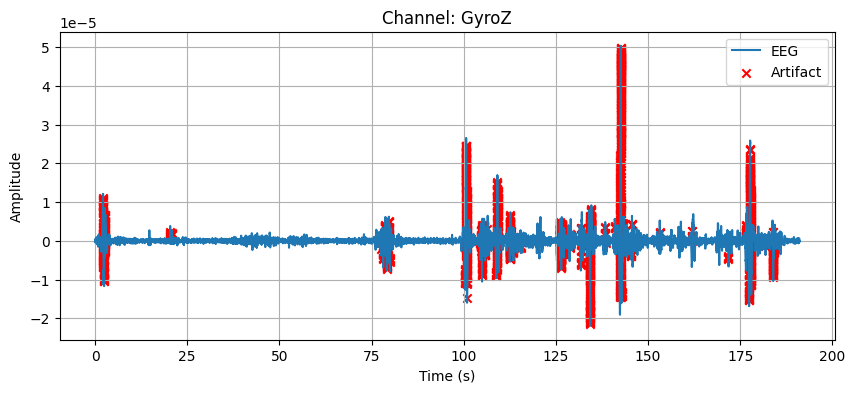

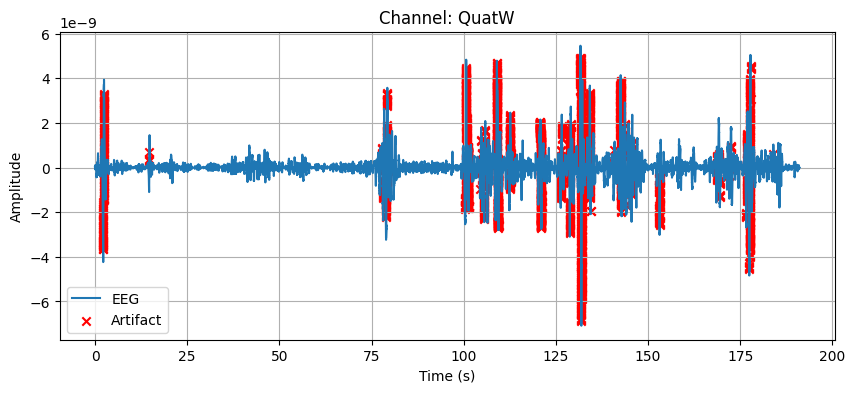

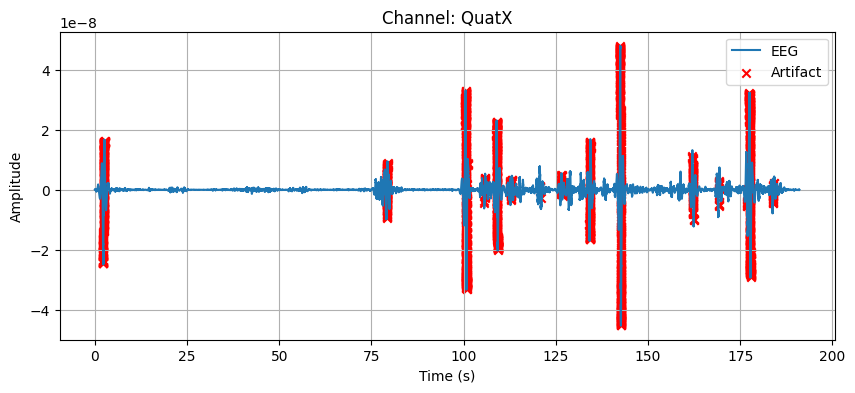

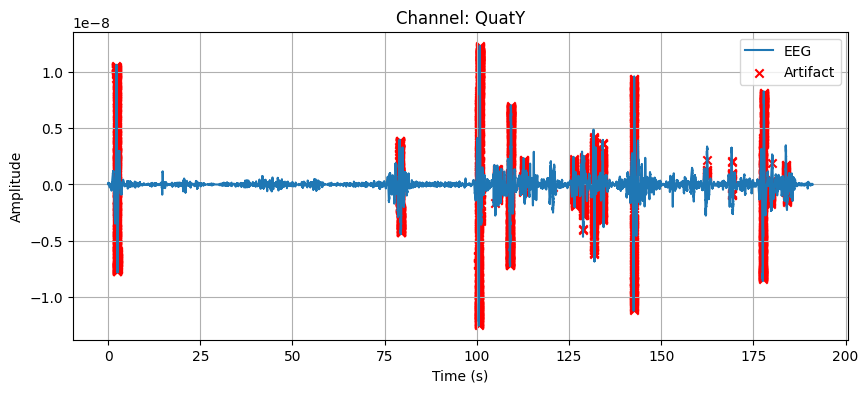

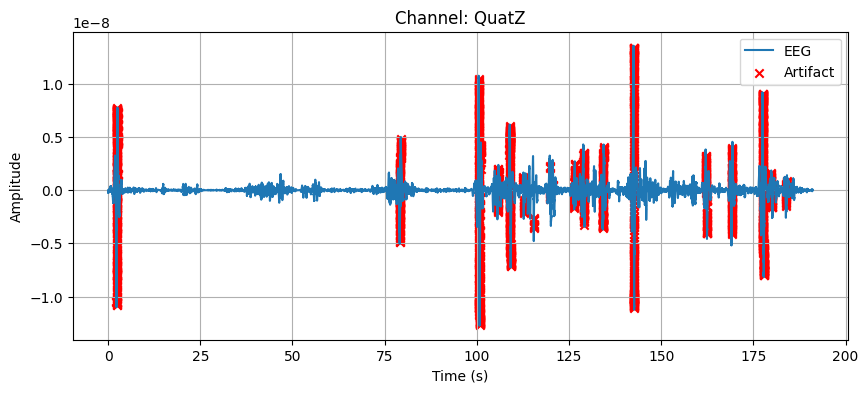

In [ ]:
eeg_raw = mne.io.read_raw_eeglab(r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/EEG/baseline/baseline_raw.set", preload=True)
fs = eeg_raw.info['sfreq']
eeg_proc, eeg_artifacts = detect_eeg_artifacts(eeg_raw, fs)
plot_eeg_artifacts(eeg_proc, eeg_artifacts, fs)
